In [1]:
import pickle
import numpy as np
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import itertools #++++++++++
import random

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Activation
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras import layers

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


%load_ext autoreload
%autoreload 2
%matplotlib inline

## Cleaning and Preparing Images For Modeling

In [2]:
# specify my data directories, the file path for my datasets
DATADIR = "Data/chest_xray/train"
DATADIR2 = "Data/chest_xray/test"

# identify my two classes
CATEGORIES = ['NORMAL', 'PNEUMONIA']

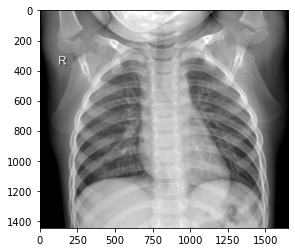

In [3]:
# iterate through all train samples of normal and pneumonia

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) # path to normal or pnuemonia directory
    for img in os.listdir(path): # view the first image in the dataset to make sure it is what I'm expecting
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) 
        # greyscale because color should not effect the classifier
        plt.imshow(img_array, cmap='gray') # view the first image
        plt.show()
        break
    break

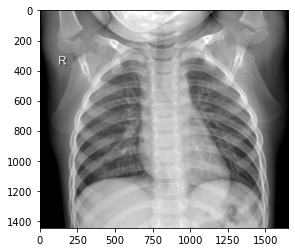

In [4]:
# repeat the same process for testing data
for category in CATEGORIES:
    path = os.path.join(DATADIR2, category)
    for img in os.listdir(path):
        img_array2 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

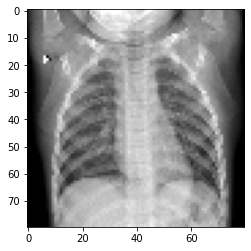

Original Image Size: (1446, 1654)
New Image Shape: (80, 80)


In [5]:
# resize the images so they are all the same size
img_size = 80


new_array = cv2.resize(img_array, (img_size, img_size))

# view an image and it's shape to ensure that the shape has changed
plt.imshow(new_array, cmap='gray') 
plt.show()

# print the original and new shapes of an image in the dataset
print(f'Original Image Size: {img_array.shape}')
print(f'New Image Shape: {new_array.shape}')

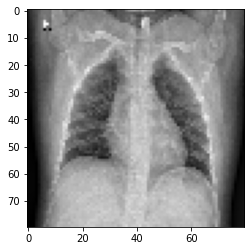

Original Image Size: (1882, 2752)
New Image Shape: (80, 80)


In [6]:
new_array2 = cv2.resize(img_array2, (img_size, img_size))
plt.imshow(new_array2, cmap='gray')
plt.show()

print(f'Original Image Size: {img_array2.shape}')
print(f'New Image Shape: {new_array2.shape}')

In [7]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category) # create numerical binary values for the target
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size)) # resize the images
                training_data.append([new_array, class_num])
            except Exception as e: # pass over any broken images
                pass
create_training_data()
print(f'Number of Photos in Training Data: {len(training_data)}')

Number of Photos in Training Data: 5216


In [8]:
test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR2, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array2 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array2 = cv2.resize(img_array2, (img_size, img_size))
                test_data.append([new_array2, class_num])
            except Exception as e:
                pass
create_test_data()
(f'Number of Photos in Test Data: {len(test_data)}')

'Number of Photos in Test Data: 624'

In [9]:
# shuffle the data so the target variables are properly mixed
random.shuffle(training_data)
random.shuffle(test_data)

In [10]:
# Check that the above line of code worked
for sample in training_data[:10]:
    print(sample[1])

1
1
0
1
1
1
1
0
1
1


In [11]:
# seperate the features and the target variables into X and y
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

#scale the data
X = X/255.

In [12]:
# seperate the features and the target variables into X_test and y_test
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#scale the data
X_test = X_test/255.

## Baseline Model

In [13]:
# what is my accuracy and recall if I just predicted most frequent every time
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X, y)
baseline_acc = round(dummy.score(X, y), 2) * 100
print('Baseline Accuracy: {0}%'.format(baseline_acc))

Baseline Accuracy: 74.0%


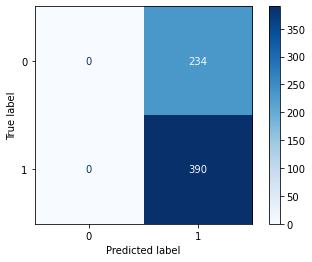

In [14]:
plot_confusion_matrix(estimator=dummy, X=X_test, y_true=y_test, cmap='Blues')

In [15]:
print(f'Train X-Rays With Pneumonia: {sum(y==1)}')
print(f'Train X-Rays Without Pneumonia: {sum(y==0)}')

Train X-Rays With Pneumonia: 3875
Train X-Rays Without Pneumonia: 1341


Given the results from my baseline model and after looking at my target variable quantities, it is clear that there is a class imbalance. The majority of these X-rays are of children with pneumonia. If we were to create a model without first fixing the class imbalance, I may have a CNN that under-represents my minority class, but is still at least 74% accurate. We could also have 100% recall. That 100% recall will be hard to beat, but with a different model in this case a slightly lower recall will provide a better balance between false negatives and false positives.

In [16]:
print(f'Test X-Rays With Pneumonia: {sum(y_test==1)}')
print(f'Test X-Rays Without Pneumonia: {sum(y_test==0)}')

Test X-Rays With Pneumonia: 390
Test X-Rays Without Pneumonia: 234


In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Model 1

In [19]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
])

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_score = model.fit(X, y, batch_size=32, validation_split=0.1, epochs=3)

Epoch 1/3
147/147 [==============================] - 28s 182ms/step - loss: 0.4092 - accuracy: 0.8161 - val_loss: 0.2502 - val_accuracy: 0.9100
Epoch 2/3
147/147 [==============================] - 27s 184ms/step - loss: 0.2509 - accuracy: 0.8933 - val_loss: 0.2588 - val_accuracy: 0.8870
Epoch 3/3
147/147 [==============================] - 25s 171ms/step - loss: 0.2271 - accuracy: 0.9131 - val_loss: 0.2126 - val_accuracy: 0.9042


In [26]:
model_score = model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 46ms/step - loss: 0.3036 - accuracy: 0.8958


In [35]:
pred1 = model.predict(X_test)
pred1 = np.round(pred1)

cm = confusion_matrix(y_test, pred1)
tn, fp, fn, tp = cm.ravel()

recall = round((tp/(tp+fn)*100), 0)
accuracy = round((model_score[1] * 100),0)


print('CNN Model 1 Accuracy: {}%'.format(accuracy))
print('CNN Model 1 Recall: {}%'.format(recall))

CNN Model 1 Accuracy: 90.0%
CNN Model 1 Recall: 95.0%


## Model 2

In [42]:
model2 = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D()
])

model2.add(Flatten())
model2.add(Dense(20, activation='relu', input_shape=X.shape[1:])) # 2 hidden layers
model2.add(Dense(7, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.fit(X, y, epochs=3, batch_size=32)

Epoch 1/3
163/163 [==============================] - 11s 62ms/step - loss: 0.4843 - accuracy: 0.7431
Epoch 2/3
163/163 [==============================] - 10s 61ms/step - loss: 0.2936 - accuracy: 0.8729
Epoch 3/3
163/163 [==============================] - 10s 61ms/step - loss: 0.2446 - accuracy: 0.8978


In [43]:
model_score2 = model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 41ms/step - loss: 0.3036 - accuracy: 0.8958


In [60]:
pred2 = model2.predict(X_test)
pred2 = np.round(pred2)

cm = confusion_matrix(y_test, pred2)
tn2, fp2, fn2, tp2 = cm.ravel()

recall2 = round((tp2/(tp2+fn2)*100), 0)
accuracy2 = round((model_score2[1] * 100),0)

print('CNN Model 2 Accuracy: {}%'.format(accuracy2))
print('CNN Model 2 Recall: {}%'.format(recall2))

CNN Model 2 Accuracy: 90.0%
CNN Model 2 Recall: 99.0%


## Model 3

In [45]:
model3 = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D()
])

model3.add(Flatten())
model3.add(Dense(20, activation='relu', input_shape=X.shape[1:])) # 2 hidden layers
model3.add(Dense(7, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(6, activation='relu'))
model3.add(Dense(5, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.fit(X, y, epochs=3, batch_size=32)

Epoch 1/3
163/163 [==============================] - 12s 65ms/step - loss: 0.5376 - accuracy: 0.7423
Epoch 2/3
163/163 [==============================] - 10s 63ms/step - loss: 0.3758 - accuracy: 0.7826
Epoch 3/3
163/163 [==============================] - 10s 61ms/step - loss: 0.3414 - accuracy: 0.8708


In [48]:
model_score3 = model3.evaluate(X_test, y_test)

20/20 [==============================] - 0s 20ms/step - loss: 0.4645 - accuracy: 0.8237


In [59]:
pred3 = model3.predict(X_test)
pred3 = np.round(pred3)

cm = confusion_matrix(y_test, pred3)
tn3, fp3, fn3, tp3 = cm.ravel()

recall3 = round((tp3/(tp3+fn3)*100), 0)
accuracy3 = round((model_score3[1] * 100),0)

print('CNN Model 3 Accuracy: {}%'.format(accuracy3))
print('CNN Model 3 Recall: {}%'.format(recall3))

CNN Model 3 Accuracy: 82.0%
CNN Model 3 Recall: 99.0%


## Model 4

In [50]:
model4 = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D()
])

model4.add(Flatten())
model4.add(Dense(20, activation='relu', input_shape=X.shape[1:]))
model4.add(Dropout(0.2))
model4.add(Dense(7, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(6, activation='relu'))
model4.add(Dense(5, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4.fit(X, y, epochs=7, batch_size=32)

Epoch 1/7
163/163 [==============================] - 12s 63ms/step - loss: 0.5914 - accuracy: 0.7358
Epoch 2/7
163/163 [==============================] - 12s 74ms/step - loss: 0.4805 - accuracy: 0.7429
Epoch 3/7
163/163 [==============================] - 13s 77ms/step - loss: 0.4441 - accuracy: 0.7429
Epoch 4/7
163/163 [==============================] - 13s 78ms/step - loss: 0.4178 - accuracy: 0.7429
Epoch 5/7
163/163 [==============================] - 11s 65ms/step - loss: 0.4020 - accuracy: 0.7429
Epoch 6/7
163/163 [==============================] - 10s 64ms/step - loss: 0.3988 - accuracy: 0.7429
Epoch 7/7
163/163 [==============================] - 10s 63ms/step - loss: 0.3835 - accuracy: 0.7630


In [51]:
model_score4 = model4.evaluate(X_test, y_test)

20/20 [==============================] - 1s 18ms/step - loss: 0.4238 - accuracy: 0.9103


In [58]:
pred4 = model4.predict(X_test)
pred4 = np.round(pred4)

cm = confusion_matrix(y_test, pred4)
tn4, fp4, fn4, tp4 = cm.ravel()

recall4 = round((tp4/(tp4+fn4)*100), 0)
accuracy4 = round((model_score4[1] * 100),0)

print('CNN Model 4 Accuracy: {}%'.format(accuracy4))
print('CNN Model 4 Recall: {}%'.format(recall4))

CNN Model 4 Accuracy: 91.0%
CNN Model 4 Recall: 92.0%


## Model 5

In [53]:
model5 = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D()
])

model5.add(Flatten())
model5.add(Dense(20, activation='relu', input_shape=X.shape[1:]))
model5.add(Dense(7, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(7, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(6, activation='relu'))
model5.add(Dense(5, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model5.fit(X, y, epochs=6, batch_size=32)

Epoch 1/6
163/163 [==============================] - 12s 65ms/step - loss: 0.5196 - accuracy: 0.7391
Epoch 2/6
163/163 [==============================] - 10s 63ms/step - loss: 0.3669 - accuracy: 0.8094
Epoch 3/6
163/163 [==============================] - 10s 63ms/step - loss: 0.3569 - accuracy: 0.8528
Epoch 4/6
163/163 [==============================] - 11s 66ms/step - loss: 0.3175 - accuracy: 0.8865
Epoch 5/6
163/163 [==============================] - 11s 69ms/step - loss: 0.2974 - accuracy: 0.8976
Epoch 6/6
163/163 [==============================] - 11s 66ms/step - loss: 0.2723 - accuracy: 0.9070


In [54]:
model_score5 = model5.evaluate(X_test, y_test)

20/20 [==============================] - 1s 18ms/step - loss: 0.3744 - accuracy: 0.8958


In [57]:
pred5 = model5.predict(X_test)
pred5 = np.round(pred5)

cm = confusion_matrix(y_test, pred5)
tn5, fp5, fn5, tp5 = cm.ravel()

recall5 = round((tp5/(tp5+fn5)*100), 0)
accuracy5 = round((model_score5[1] * 100),0)

print('CNN Model 5 Accuracy: {}%'.format(accuracy5))
print('CNN Model 5 Recall: {}%'.format(recall5))

CNN Model 5 Accuracy: 90.0%
CNN Model 5 Recall: 94.0%


## Final Model
Based on my CNN model performance I have determined that model 2 would be the best model to use to predict pneumonia in children under the age of 5. Model 2 and model 3 both had a recall of 99%, but I chose model 2 because it has an accuracy of 90% compared to model 3's accuracy of 82%.

In [61]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 80, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                512020    
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                